## Deep Learning with PyTorch : Neural Style Transfer

In [ ]:
!pip install torch torchvision

## Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained= True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
for prameters in vgg.parameters():
  prameters.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from PIL import Image
from torchvision import transforms as T 

def preprocess(img_path, max_size=500):
  image = Image.open(img_path).convert("RGB")

  if max(image.size) > max_size:
    size= max_size
  
  else: 
    size = max(image.size)
  

  image_transforms = T.Compose([
                                T.Resize(size),
                                T.ToTensor(),
                                T.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
  ])
  image = image_transforms(image)
  image= image.unsqueeze(0) #(3,224,224) -> (1,3,224,224)
  return image

In [ ]:
content_p = preprocess('/content/Project-NST/content11.jpg')
style_p = preprocess('/content/Project-NST/style12.jpg')

content_p = content_p.to(device)
style_p = style_p.to(device)

print('content shape', content_p.shape)
print('style shape' , style_p.shape)

content shape torch.Size([1, 3, 259, 345])
style shape torch.Size([1, 3, 625, 500])


## Deprocess image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):

  image= tensor.to('cpu').clone()
  image = image.numpy()
  image= image.squeeze(0)
  image= image.transpose(1,2,0)
  image= image *np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image 
  

In [ ]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print('deprocess content shape', content_d.shape)
print('deprocess style shape' , style_d.shape)

deprocess content shape (259, 345, 3)
deprocess style shape (625, 500, 3)


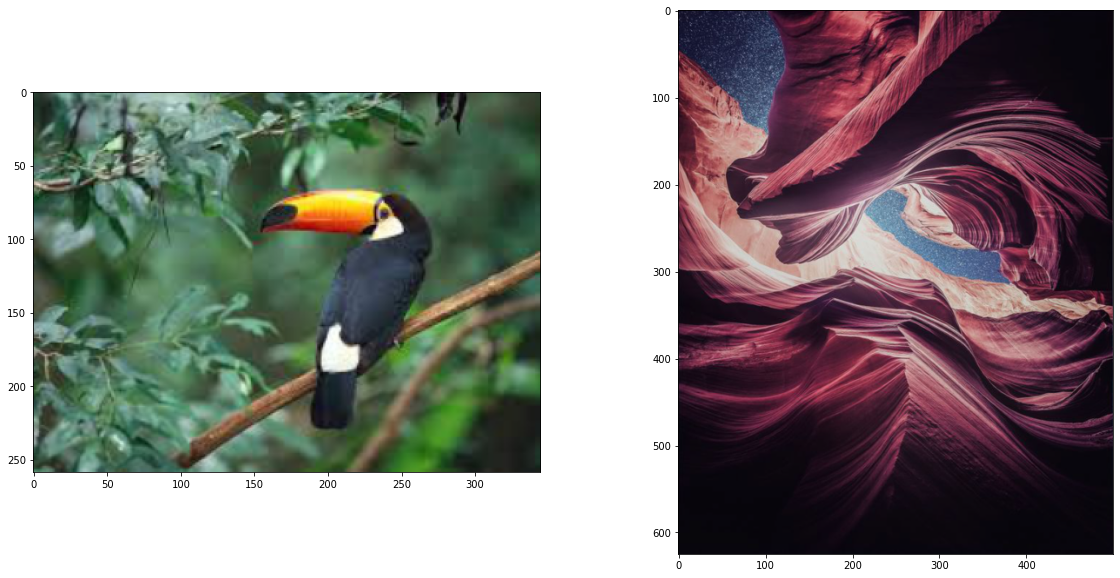

In [ ]:
fig, (ax1, ax2)= plt.subplots(1,2,figsize=(20,10))

ax1.imshow(content_d)
ax2.imshow(style_d)

##  Get content,style features and create gram matrix

In [ ]:
def get_features(image, model):

  layers= {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10': 'conv3_1',
      '19':'conv4_1',
      '21':'conv4_2', #content_feature
      '28':'conv5_1'

  }

  x = image 
  Features = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]]= x
  return Features

In [ ]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


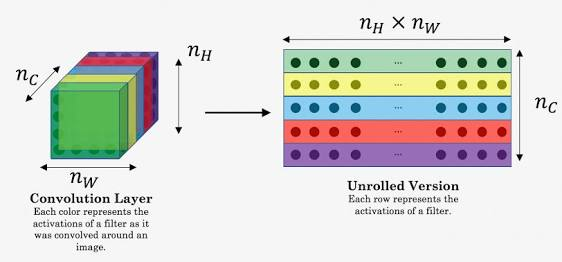

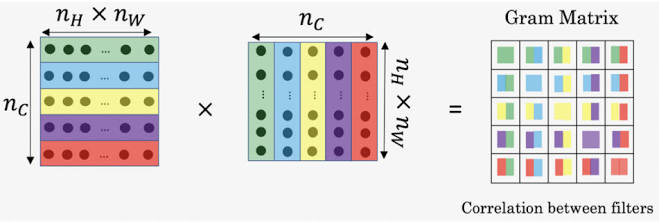

In [ ]:
def gram_metrix(tensor):

  b,c,h,w = tensor.size()
  tensor= tensor.view(c, h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram


In [ ]:
style_grams = {layer: gram_metrix(style_f[layer]) for layer in style_f}

## Creating Style and Content loss function

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [ ]:
style_weights={ 'conv1_1':1.0,
               'conv2_1':0.75,
               'conv3_1':0.2,
               'conv4_1':0.2,
               'conv5_1':0.2,
               
}

In [ ]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_metrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

In [ ]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print("content loss: ", content_loss(target_f['conv4_2'],content_f['conv4_2']))
print('style loss: ',style_loss(style_weights, target_f, style_grams))

content loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
style loss:  tensor(1790.8409, device='cuda:0', grad_fn=<AddBackward0>)


##  Training loop



In [ ]:
from torch import optim
optimizer = optim.Adam([target], lr=0.003)
alpha = 1
beta = 1e5
epochs = 3000
show_every= 500


In [ ]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss=alpha * c_loss + beta *s_loss
  return loss

In [ ]:
results = []
for i in range(epochs):
  target_f = get_features(target,vgg)

  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print('total loss at epoch {} : {}'. format(i,t_loss))
    results.append(deprocess(target.detach()))

total loss at epoch 0 : 179084096.0
total loss at epoch 500 : 27115848.0
total loss at epoch 1000 : 15147480.0
total loss at epoch 1500 : 11682150.0
total loss at epoch 2000 : 9617778.0
total loss at epoch 2500 : 8207447.0


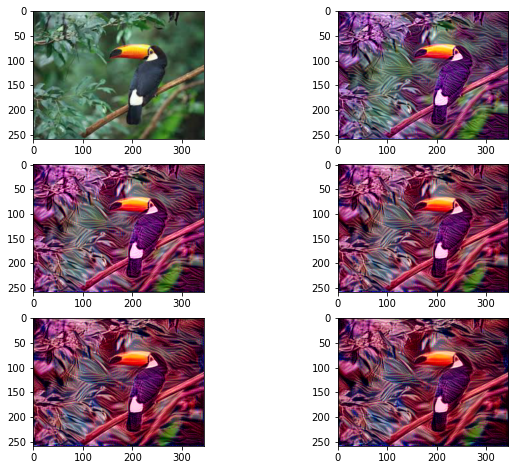

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(results)):

  plt.subplot(3,2,i+1)
  plt.imshow(results[i])

plt.show()

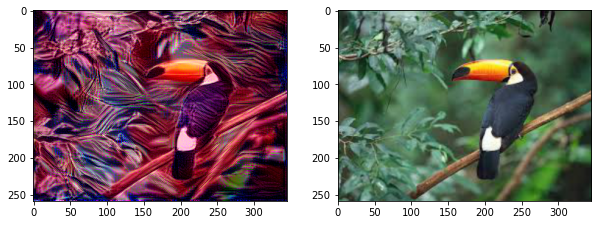

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig,(ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)
              